In [65]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [66]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

In [67]:
!ls

deleteme.ipynb	Downloads	histories	      one_more_dir  Templates
Desktop		early_hist.txt	model_parameters.pth  Pictures	    Videos
Documents	frogs_project	Music		      Public


In [68]:
opt_data = {}
for i in range(24):
#     with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
    with open(f'{ROOT_PATH}/results/sweek_with_shiftMAE_{i}.pkl','rb') as f:
        opt_data[i] = pickle.load(f)

/tmp/ipykernel_2113499/2220721299.py:5: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  opt_data[i] = pickle.load(f)
/tmp/ipykernel_2113499/2220721299.py:5: DeprecationWarning: Please use `LbfgsInvHessProduct` from the `scipy.optimize` namespace, the `scipy.optimize.lbfgsb` namespace is deprecated.
  opt_data[i] = pickle.load(f)


In [69]:
opt_data

{0: {'MAE':                     message: ['requested number of basinhopping iterations completed successfully']
                          fun: 6.937018161397665
                            x: [-4.706e+00  4.589e-02  3.354e-01  3.845e+01]
                          nit: 100
        minimization_failures: 7
                         nfev: 22915
                         njev: 4583
   lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                                success: True
                                 status: 0
                                    fun: 6.937018161397665
                                      x: [-4.706e+00  4.589e-02  3.354e-01
                                           3.845e+01]
                                    nit: 6
                                    jac: [ 0.000e+00  9.400e-01  8.191e+00
                                          -1.143e-01]
                                   nfev: 210
                                   nje

In [70]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}
fixed_params['model'] =  dict(n_inputs = 3,
        n_hidden = 5*4*512,
        n_outs = 1,
        en_bias = False,
        b_high=3, first_layer_init='ones',
        first_layer_weights_trainable = True,
        out_layer_init='zeros')         

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,1,0], 'sigma_noi':0.0, 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None}

optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('custom','w'),
                    ('postprocessing','scale'),
                    ]

custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['normalized_log_lr']/x['w']},
                            {'cathegory':'model','param_name':'nl','fun': lambda x: (lambda : OneOverSqr(w=x['w']))}]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [74]:
df = pd.read_csv(f'{ROOT_PATH}../../frogs_project/data/avraham__ivry_fig1_rotFig1_v2.csv',header=None)
df = df.T
data = df.to_numpy()

In [75]:
stimulus = [(1,40),(0,40)]
pooling_fun = 'MAE'

In [76]:
errors = [opt_data[k][pooling_fun]['fun'] for k in opt_data]


In [77]:
np.mean(errors)

4.158112369184072

In [78]:
outs  = {k: wrapped_runner([(1,40),(0,40),(1,41)],opt_data[k][pooling_fun]['x']) for k in opt_data}

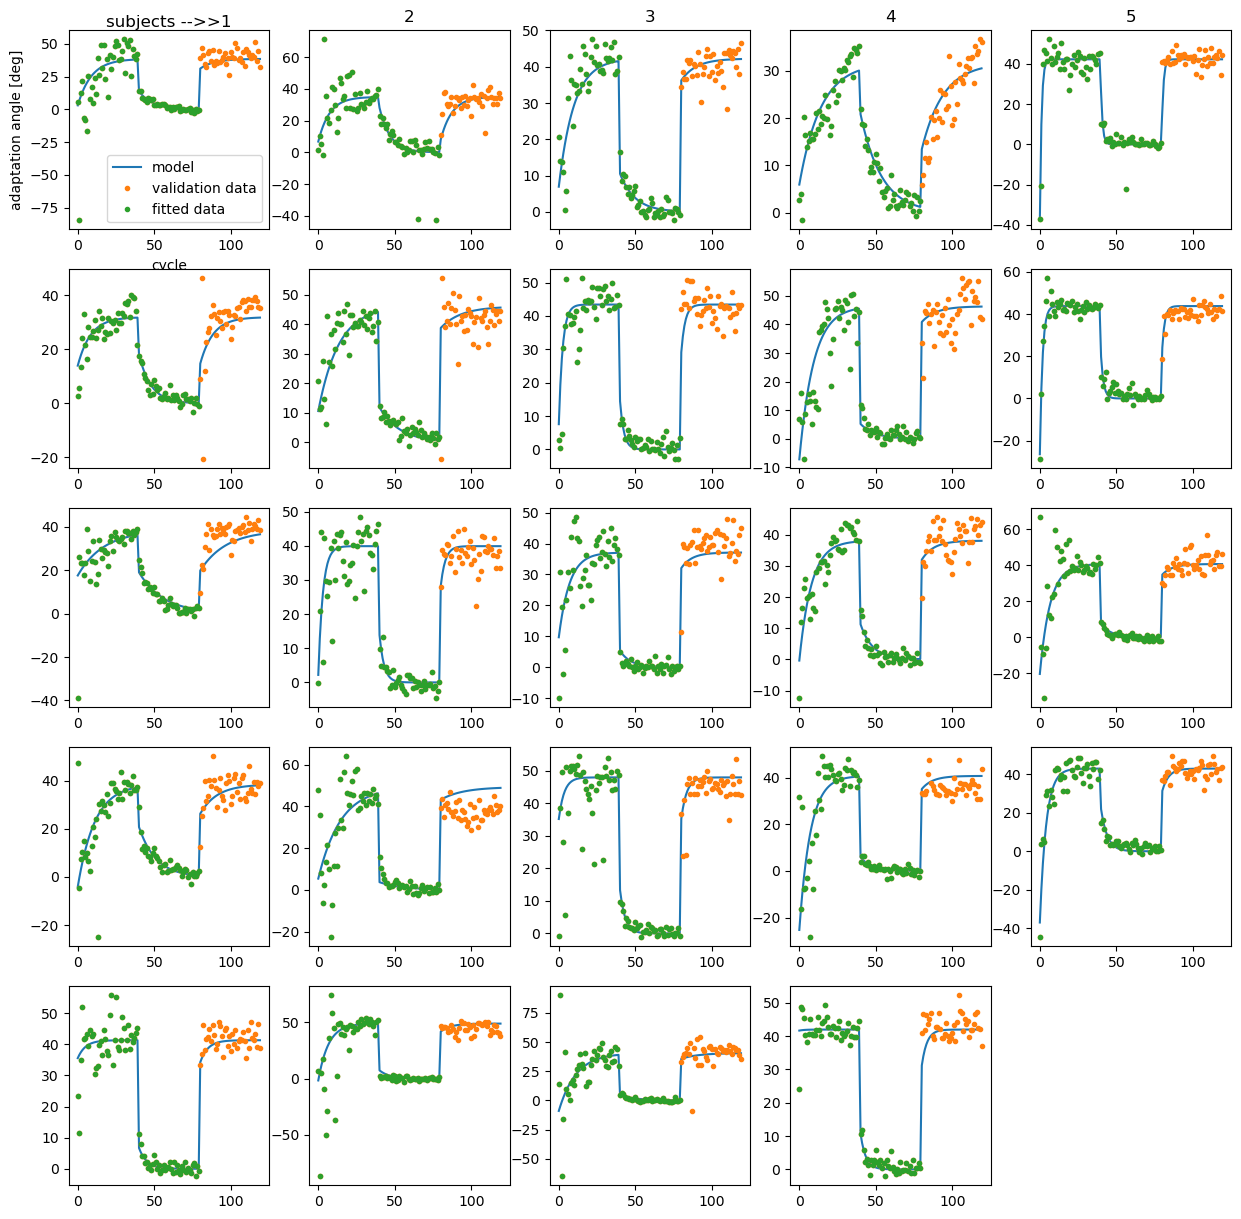

In [79]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k][1:])
    plt.plot(data[:,k],'.')
    plt.plot(data[:80,k],'.')
    if k<5: plt.title(f'{k+1}')
        

plt.subplot(5,5,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)
plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


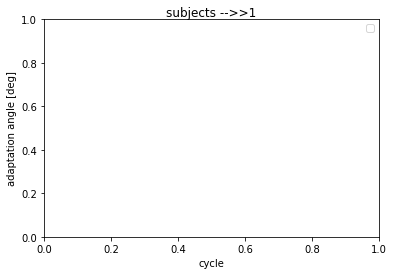

In [ ]:
plt.subplot(1,1,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-3000)
plt.legend(['model','validation data','fitted data']) 

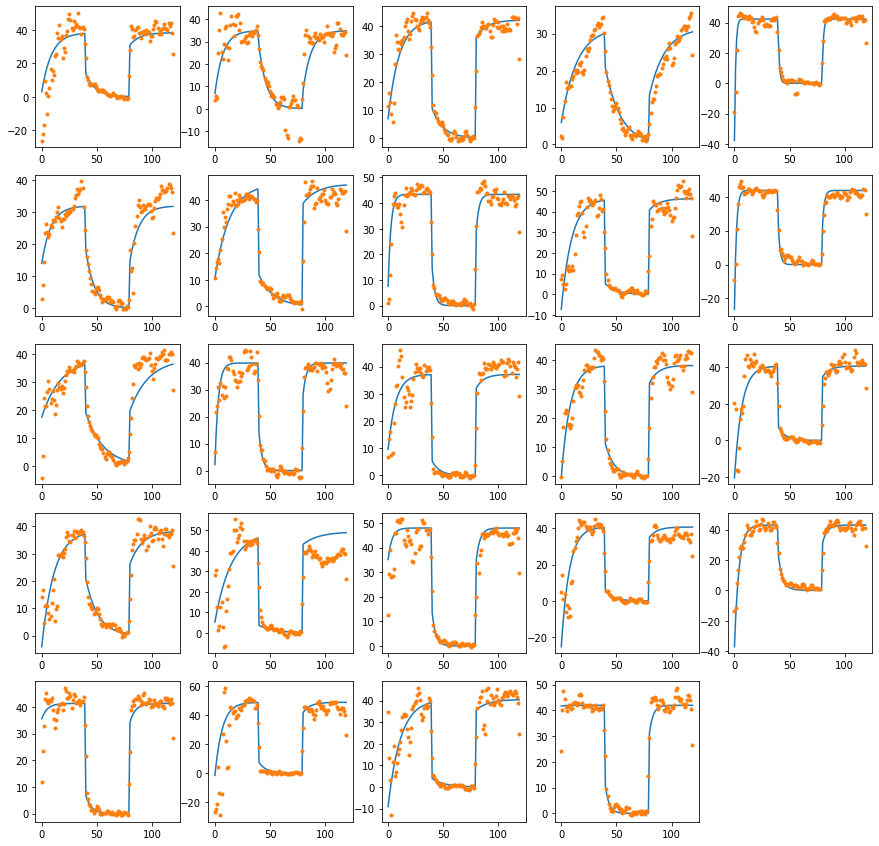

In [ ]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k][1:])
    plt.plot(smooth_signal(data[:,k],3),'.')

In [ ]:
outs_ = [o[1:] for _,o in outs.items()]
outs_ = np.array(outs_)

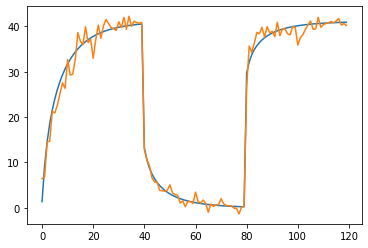

In [ ]:
plt.plot(np.mean(outs_,axis=0))
plt.plot(np.mean(data,axis=1))

In [ ]:
diffs = outs_.T-data
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2)

(77.66298747125691, 39.997709873666025)

In [ ]:
data_varia = data-np.mean(data,axis=1,keepdims=True)

In [ ]:
np.mean(data_varia**2)

83.27901569878472

In [ ]:
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2),np.mean(diffs[81:,:]**2)

(77.66298747125691, 39.997709873666025, 36.6799425022624)

In [ ]:
np.mean(data_varia[:80,:]**2),np.mean(data_varia[80:,:]**2),np.mean(data_varia[81:,:]**2)

(99.77897536675346, 50.27909636284723, 46.55323259882478)

[]

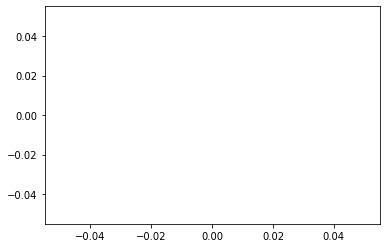

In [ ]:
plt.plot(diffs[:,80:])

In [ ]:
A_times = [0,5,10,20] 
antero   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

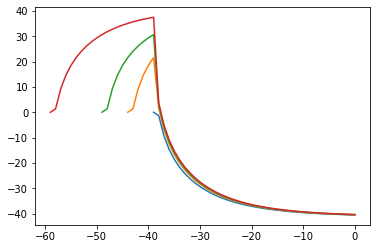

In [ ]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [ ]:
frog_ens = [True,False]
Tfrog = 220
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

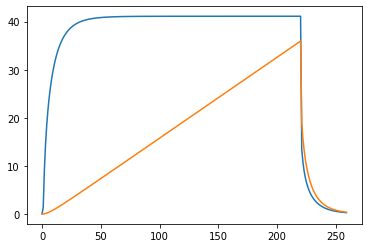

In [ ]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
for setting in pooling_funs +[appendix]:
    plt.plot(outs[setting])
plt.plot(data[:,0],'x')
plt.plot(data[:80,0],'x')

plt.xlim([39,120])
plt.ylim([-5,60])


NameError: name 'pooling_funs' is not defined

In [ ]:
mae = lambda x: np.mean(np.abs(x))
mse = lambda x: np.mean(np.square(x))


In [ ]:
for setting in pooling_funs +[appendix]:
    fit_err = outs[setting][:80] - data[:80,0]
    val_err = outs[setting][80:] - data[80:,0]
    print(f'fit objective: {setting}')
    print(f' fitting MAE: {mae(fit_err)}; MSE: {mse(fit_err)}')
    print(f' validation MAE: {mae(val_err)}; MSE: {mse(val_err)}')

In [ ]:
import scipy
scipy.__version__

In [ ]:
# !pip3 install --upgrade pip

In [ ]:
# pip install --upgrade scipy

In [ ]:
import pickle

In [ ]:
with open('sweep_1_subj_12.pkl','rb') as f:
    opt_data = pickle.load(f)

In [ ]:
opt_data